# Calculating MS5351M PLL Settings


There are several parameters that we can modify to choose the output frequency. The constraint that we want quadrature I/Q outputs as part of CLK0 and CLK1 provides a strong restriction on possible frequencies. We only use PLLA for the quadrature output, as the frequencies are identical.

The constraints are:
* Quadrature requires an even multiple, $N$, of the output frequency to be the PLL frequency. The delay register (CLKx_PHOFF) must then be set to $N$, to get the quadrature output on the second clock.
* The PLL frequency must be between 600 and 900 MHz
* THe input clock is $f_{clk} = 25$ MHz.
* Above 150 MHz, the output divide ratio, $M_{output} R$, must be 4.
		
The output frequency is given by the expression
$$ f_{vco} = (f_{clk} / D) * M_{feedback} $$
$$ f_{out} = \frac{f_{vco}}{M_{output} R} $$


$$ M_{feedback} = a + b/c $$
where a, b, c are roughly integers

P1[17:0] = (a << 7) + 



In [1]:
import math

def multisynth(f_clk, a, b, c, d):
    return (f_clk/d) * (a + b/c)


def get_closest_vco(f_clk, vco_previous, vco_desired):
    best = {}
    best['fit'] = 9e99

    for d in [1, 2, 4, 8]:
        for a in range(1, 90):
            for b in range(0, 90):
                for c in range(1, 5000):
                    
                    m = a + b/c
                    if m < 15:
                        break
                    if m > 90:
                        break
                        
                    f_vco = multisynth(f_clk, a, b, c, d)
                    df = f_vco - vco_desired
                    fit = math.sqrt(df*df)
                    if fit < best['fit']:
                        best['fit'] = fit
                        best['a'] = a
                        best['b'] = b
                        best['c'] = c
                        best['d'] = d
                        best['f_vco'] = f_vco
                        best['df'] = df
                    if fit < 1.0:
                        return best
    print(best)            
    return best
        
def synth(f_clk, f_desired):
    ret = {}
    
    if f_desired > 150e6:
        n_start = 2
        n_stop = 2
        N = 4
    else:
        # Search for best f_vco (an even integer multiple)        
        n_stop = math.floor(900e6 / (2*f_desired))+1
        n_start = math.floor(600e6 / (2*f_desired))
                
    best = {}
    best['fit'] = 9e99
        
    for n in range(n_start, n_stop+1):
        N = 2*n # Use even multipliers only for quadrature
        f_vco = f_desired*N
        if (f_vco > 600e6) and (f_vco < 900e6):
            # Now try and get f_vco from f_in
                
            test = get_closest_vco(f_clk, f_vco, f_vco)
                
            if test['fit'] < best['fit']:
                best = test
                    
            if best['fit'] < 1:
                break
    ret['multisynth'] = best
    ret['f'] = best['f_vco']/N
    ret['N'] = N

    
    return ret

In [2]:
synth(25e6, 13580000)

{'fit': 512.8205128908157, 'a': 49, 'b': 38, 'c': 39, 'd': 2, 'f_vco': 624679487.1794871, 'df': -512.8205128908157}


{'multisynth': {'fit': 0.0,
  'a': 26,
  'b': 46,
  'c': 625,
  'd': 1,
  'f_vco': 651840000.0,
  'df': 0.0},
 'f': 13580000.0,
 'N': 48}

{'fit': 69.7259771823883, 'a': 25, 'b': 25, 'c': 73, 'd': 1, 'f_vco': 633561643.8356165, 'df': -69.7259771823883}
{'fit': 9113.100670814514, 'a': 33, 'b': 49, 'c': 62, 'd': 1, 'f_vco': 844758064.516129, 'df': 9113.100670814514}
105593618.92693228 {'multisynth': {'fit': 69.7259771823883, 'a': 25, 'b': 25, 'c': 73, 'd': 1, 'f_vco': 633561643.8356165, 'df': -69.7259771823883}, 'f': 63356164.38356165, 'N': 10}
dict_keys(['multisynth', 'f', 'N'])
{'fit': 675.6544908285141, 'a': 27, 'b': 57, 'c': 124, 'd': 1, 'f_vco': 686491935.483871, 'df': -675.6544908285141}
{'fit': 9.233807444572449, 'a': 32, 'b': 47, 'c': 1294, 'd': 1, 'f_vco': 800908037.0942813, 'df': -9.233807444572449}
57207717.59486348 {'multisynth': {'fit': 9.233807444572449, 'a': 32, 'b': 47, 'c': 1294, 'd': 1, 'f_vco': 800908037.0942813, 'df': -9.233807444572449}, 'f': 50056752.31839258, 'N': 16}
dict_keys(['multisynth', 'f', 'N'])
{'fit': 271.4384070634842, 'a': 25, 'b': 61, 'c': 257, 'd': 1, 'f_vco': 630933852.1400778, 'df': 27

{'fit': 89.5184828042984, 'a': 30, 'b': 43, 'c': 178, 'd': 1, 'f_vco': 756039325.8426967, 'df': -89.5184828042984}
{'fit': 16.862661838531494, 'a': 31, 'b': 37, 'c': 628, 'd': 1, 'f_vco': 776472929.9363056, 'df': 16.862661838531494}
{'fit': 16666.13696885109, 'a': 31, 'b': 57, 'c': 65, 'd': 1, 'f_vco': 796923076.923077, 'df': 16666.13696885109}


KeyboardInterrupt: 

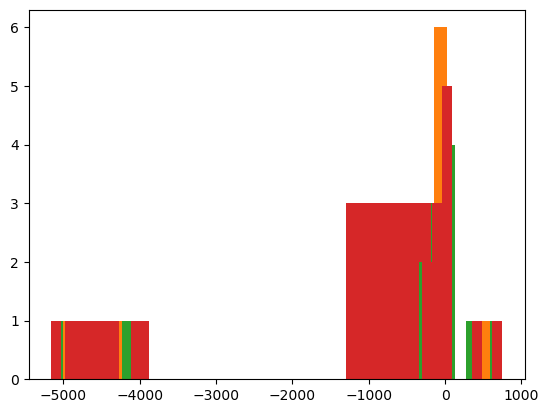

In [3]:
import numpy as np
import matplotlib.pyplot as plt


freq = np.random.uniform(low=1e6, high=150e6, size=1000)
data = []

for f in freq:
    x = synth(25e6, f)
    print(f, x)
    print(x.keys())
    data.append(x['multisynth']['df'])
    plt.hist(data, bins='fd')

## Band Plans

Above shows that we can do quadrature synthesis within about 10 Hz of most frequencies. This brute force approach does require a bit too much computation, so we come up with a band plan, over a limited range of frequencies. The basic idea is to use a low VCO frequency at the low end of the band, and to change only one of the synthesizer numbers (either b or c). So a band has a fixed choice of the output divider (for quadrature), and changes only the VCO frequency using a fixed $a$ and $b$

The idea is to choose a delta_f for the band as well as f_low and f_high

In [17]:
import sympy as sp

f_low = sp.Symbol('f_low')
f_high = sp.Symbol('f_high')
N = sp.Symbol('N')
f_clk = sp.Symbol('f_clk')

a = sp.Symbol('a')
c = sp.Symbol('c')
b = sp.Symbol('b')
f_vco = f_clk * (a + b/c)
f = f_vco / N
f1 = f.subs(b,b+1)
f0 = f.subs(b, 0)
f

f_clk*(a + b/c)/N

In [16]:
delta_f = sp.simplify(f1 - f)
delta_f

f_clk/(N*c)

In [18]:
f0

a*f_clk/N

So step 1 is to figure out $N$ which is the even clock output multiplier. This is done by using $f_{low}$ and setting the $f_{vco}$ to be just above 600 MHz.

N = 2 ceil(600000000 / f_{low})

In [22]:
f_low = 50e6
N =  2*np.ceil(600000000 / (2*f_low) )
N

12.0

Then, once N is established, use f_low to calculate $a$
$$ a = N* \frac{f_{low}}{f_{clk}} $$

In [42]:
f_clk = 25e6
a = np.round(N * f_low / f_clk)
a

24.0

Now work out $c$ from the expression for delta_f.

In [36]:
delta_f = 100
c = np.ceil(f_clk / (N * delta_f))
c

20834.0

In [37]:
delta_f = f_clk / (N*c)
delta_f

99.99680010239672

In [38]:
def f(b):
    return f_clk*(a + b/c)/N
    
f(1)

50000099.996800095

In [39]:
f(2)

50000199.99360021

In [41]:
f(10000)

50999968.00102397